In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve
)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Transformer Imports
from transformers import (
    BertModel,
    BertTokenizer,
    VisualBertModel,
    VisualBertConfig,
    CLIPProcessor,
    CLIPModel
)

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
import os

drive.mount('/content/drive')

rar_path = '/content/drive/MyDrive/data.rar'
target_dir = '/content/dataset'

if not os.path.exists(target_dir):
    os.makedirs(target_dir)
!unrar x "{rar_path}" "{target_dir}/"

print(f"Extraction complete. Data is now in {target_dir}")

Streaming output truncated to the last 5000 lines.
Extracting  /content/dataset/data/raw/HM Dataset/img/49805.png            49%  OK 
Extracting  /content/dataset/data/raw/HM Dataset/img/49806.png            49%  OK 
Extracting  /content/dataset/data/raw/HM Dataset/img/49807.png            49%  OK 
Extracting  /content/dataset/data/raw/HM Dataset/img/49810.png            49%  OK 
Extracting  /content/dataset/data/raw/HM Dataset/img/49826.png            49%  OK 
Extracting  /content/dataset/data/raw/HM Dataset/img/49831.png            49%  OK 
Extracting  /content/dataset/data/raw/HM Dataset/img/49832.png            49%  OK 
Extracting  /content/dataset/data/raw/HM Dataset/img/49836.png            49%  OK 
Extracting  /content/dataset/data/raw/HM Dataset/img/49850.png            49%  OK 
Extracting  /content/dataset/data/raw/HM Dataset/img/49856.png            49%  OK 
Extracting  /content/dataset/

### Global Configuration

In [3]:
class Config:
    seed = 42
    img_size = 224
    batch_size = 32
    epochs = 5      # Reduced for demonstration; set to 10+ for real training
    lr_clip = 1e-5
    lr_bert = 2e-5
    weight_decay = 1e-2
    patience = 3
    max_len = 77
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model Identifiers
    clip_model_name = "openai/clip-vit-base-patch32"
    bert_model_name = "bert-base-uncased"
    visualbert_model_name = "uclanlp/visualbert-vqa-coco-pre"

    # Data Paths (Update these to your actual paths)
    data_root = "/content/dataset/data/raw/HM Dataset"
    train_path = "/content/dataset/data/processed/train_metadata.csv"
    dev_path = "/content/dataset/data/processed/dev_metadata.csv"
    test_path = "/content/dataset/data/processed/test_metadata.csv"

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(Config.seed)
print(f"Device: {Config.device}")

Device: cuda


### Data Preparation Utils

In [5]:
def load_and_preprocess_data(root_dir):
    try:
        train_df = pd.read_csv(Config.train_path)
        dev_df = pd.read_csv(Config.dev_path)
        test_df = pd.read_csv(Config.test_path)
    except FileNotFoundError:
        print("Metadata CSVs not found. Please ensure paths in Config are correct.")
        return None, None, None

    def fix_paths_and_labels(df, name):
        # Normalize labels
        for col in ['labels', 'class']:
            if col in df.columns:
                df = df.rename(columns={col: 'label'})

        if 'label' not in df.columns:
            df['label'] = 0

        # Fix image paths
        def get_path(img_id):
            filename = os.path.basename(str(img_id))
            if not filename.endswith('.png'): filename += '.png'

            candidates = [
                os.path.join(root_dir, 'img', filename),
                os.path.join(root_dir, filename)
            ]
            for p in candidates:
                if os.path.exists(p): return p
            return None

        df['full_path'] = df['img'].apply(get_path)
        df = df.dropna(subset=['full_path'])
        return df

    train_df = fix_paths_and_labels(train_df, "Train")
    dev_df = fix_paths_and_labels(dev_df, "Val")
    test_df = fix_paths_and_labels(test_df, "Test")

    return train_df, dev_df, test_df

### Data Preprocessing

In [6]:
train_transforms = transforms.Compose([
    transforms.Resize((Config.img_size, Config.img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
val_transforms = transforms.Compose([
    transforms.Resize((Config.img_size, Config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Visualization Function

In [8]:
# Global dictionary to store results for final comparison
model_comparison = {'Model': [], 'Accuracy': [], 'AUC': []}

In [9]:
def visualize_results(model_name, y_true, y_probs, y_pred):
    """Generates metrics and plots. Handles cases with no labels."""
    if len(np.unique(y_true)) < 2:
        print(f"Skipping visualization for {model_name}: Ground truth has only one class (or no labels).")
        return

    print(f"\n{'='*20} {model_name} FINAL EVALUATION {'='*20}")
    acc = accuracy_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_probs)

    print(f"Accuracy: {acc:.4f} | ROC-AUC: {auc_score:.4f}")
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

    # Log to global comparison if it exists
    if 'model_comparison' in globals():
        global model_comparison
        model_comparison['Model'].append(model_name)
        model_comparison['Accuracy'].append(acc)
        model_comparison['AUC'].append(auc_score)

### Model 1 - CLIP (Contrastive Language-Image Pre-training)

In [10]:
class CLIPDataset(Dataset):
    def __init__(self, dataframe, processor):
        self.df = dataframe.reset_index(drop=True)
        self.processor = processor

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['full_path']).convert('RGB')
        text = str(row['text'])

        inputs = self.processor(text=text, images=image, return_tensors="pt", padding="max_length", max_length=Config.max_len, truncation=True)

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'pixel_values': inputs['pixel_values'].squeeze(0),
            'label': torch.tensor(row['label'], dtype=torch.float)
        }

In [11]:
class HatefulMemeCLIP(nn.Module):
    def __init__(self, model_name=Config.clip_model_name, dropout=0.5):
        super().__init__()
        self.clip = CLIPModel.from_pretrained(model_name)
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 1)
        )
    def forward(self, input_ids, attention_mask, pixel_values):
        outputs = self.clip(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)
        combined = torch.cat((outputs.text_embeds, outputs.image_embeds), dim=1)
        return self.classifier(combined)

### Model 2 - ResNet + Transformer (Late Fusion)

In [12]:
class ResNetBERTDataset(Dataset):
    def __init__(self, dataframe, tokenizer, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['full_path']).convert('RGB')

        if self.transform: image = self.transform(image)

        text_inputs = self.tokenizer(str(row['text']), padding='max_length', truncation=True, max_length=128, return_tensors='pt')

        return {
            'input_ids': text_inputs['input_ids'].squeeze(0),
            'attention_mask': text_inputs['attention_mask'].squeeze(0),
            'pixel_values': image,
            'label': torch.tensor(row['label'], dtype=torch.float)
        }

In [13]:
class HatefulMemeResNetBERT(nn.Module):
    def __init__(self, bert_model_name=Config.bert_model_name):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        self.visual_encoder = nn.Sequential(*list(resnet.children())[:-1])
        self.vis_project = nn.Linear(2048, 512)
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.text_project = nn.Linear(768, 512)
        self.classifier = nn.Sequential(
            nn.Dropout(0.3), nn.Linear(1024, 128), nn.ReLU(), nn.Linear(128, 1)
        )
    def forward(self, input_ids, attention_mask, pixel_values):
        img_feat = self.vis_project(self.visual_encoder(pixel_values).squeeze())
        text_feat = self.text_project(self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output)
        combined = torch.cat((img_feat, text_feat), dim=1)
        return self.classifier(combined)

### Model 3 - VisualBERT (Early Fusion)

In [14]:
class VisualBERTDataset(Dataset):
    def __init__(self, dataframe, tokenizer, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['full_path']).convert('RGB')

        if self.transform: pixel_values = self.transform(image)

        text_inputs = self.tokenizer(str(row['text']), padding='max_length', truncation=True, max_length=128, return_tensors='pt')

        return {
            'input_ids': text_inputs['input_ids'].squeeze(0),
            'attention_mask': text_inputs['attention_mask'].squeeze(0),
            'token_type_ids': text_inputs['token_type_ids'].squeeze(0),
            'pixel_values': pixel_values,
            'label': torch.tensor(row['label'], dtype=torch.float)
        }

In [15]:
class HatefulMemeVisualBERT(nn.Module):
    def __init__(self, model_name=Config.visualbert_model_name):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        self.visual_encoder = nn.Sequential(*list(resnet.children())[:-2])
        self.config = VisualBertConfig.from_pretrained(model_name)
        self.config.visual_embedding_dim = 2048
        self.visualbert = VisualBertModel.from_pretrained(model_name, config=self.config)
        self.classifier = nn.Linear(self.visualbert.config.hidden_size, 1)
    def forward(self, input_ids, attention_mask, token_type_ids, pixel_values):
        vis_feat = self.visual_encoder(pixel_values)
        visual_embeds = vis_feat.view(vis_feat.size(0), 2048, -1).permute(0, 2, 1)
        visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long).to(Config.device)
        visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.float).to(Config.device)
        outputs = self.visualbert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, visual_embeds=visual_embeds, visual_token_type_ids=visual_token_type_ids, visual_attention_mask=visual_attention_mask)
        return self.classifier(outputs.pooler_output)

### Training Engine

In [16]:
def train_epoch(model, loader, optimizer, criterion, device, model_type="generic"):
    model.train()
    total_loss = 0
    loop = tqdm(loader, desc="Training", leave=False)
    for batch in loop:
        # Move batch to device
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device).float().unsqueeze(1)
        pixels = batch['pixel_values'].to(device)

        optimizer.zero_grad()

        if "visualbert" in model_type:
            tt_ids = batch['token_type_ids'].to(device)
            outputs = model(ids, mask, tt_ids, pixels)
        else:
            outputs = model(ids, mask, pixels)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    return total_loss / len(loader)

In [17]:
def eval_epoch(model, loader, criterion, device, model_type="generic"):
    model.eval()
    all_probs, all_labels = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            # Consistent device movement
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device).float().unsqueeze(1)
            pixels = batch['pixel_values'].to(device)

            if "visualbert" in model_type:
                tt_ids = batch['token_type_ids'].to(device)
                outputs = model(ids, mask, tt_ids, pixels)
            else:
                outputs = model(ids, mask, pixels)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy().flatten())

    avg_loss = total_loss / len(loader)

    # Calculate AUC only if both classes are present
    try:
        auc_val = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc_val = 0.5 # Default/Invalid

    return avg_loss, auc_val, all_probs, all_labels

In [20]:
def run_training(model_name, train_df, dev_df, test_df):
    print(f"\n\n>>> STARTING CONFIGURATION FOR: {model_name}")

    # 1. Setup Dataset & Loader
    if model_name == "CLIP":
        processor = CLIPProcessor.from_pretrained(Config.clip_model_name)
        train_ds = CLIPDataset(train_df, processor)
        val_ds = CLIPDataset(dev_df, processor)
        test_ds = CLIPDataset(test_df, processor)
        model = HatefulMemeCLIP()

    elif model_name == "ResNetBERT":
        tokenizer = BertTokenizer.from_pretrained(Config.bert_model_name)
        train_ds = ResNetBERTDataset(train_df, tokenizer, train_transforms)
        val_ds = ResNetBERTDataset(dev_df, tokenizer, val_transforms)
        test_ds = ResNetBERTDataset(test_df, tokenizer, val_transforms)
        model = HatefulMemeResNetBERT()

    elif model_name == "VisualBERT":
        tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        train_ds = VisualBERTDataset(train_df, tokenizer, train_transforms)
        val_ds = VisualBERTDataset(dev_df, tokenizer, val_transforms)
        test_ds = VisualBERTDataset(test_df, tokenizer, val_transforms)
        model = HatefulMemeVisualBERT()

    train_loader = DataLoader(train_ds, batch_size=Config.batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=Config.batch_size, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=Config.batch_size, shuffle=False)

    model = model.to(Config.device)
    optimizer = optim.AdamW(model.parameters(), lr=Config.lr_bert)
    criterion = nn.BCEWithLogitsLoss()

    best_auc = 0
    patience_counter = 0

    for epoch in range(Config.epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, Config.device, model_type=model_name.lower())

        val_loss, val_auc, _, _ = eval_epoch(model, val_loader, criterion, Config.device, model_type=model_name.lower())

        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val AUC: {val_auc:.4f}")

        if val_auc > best_auc:
            best_auc = val_auc
            torch.save(model.state_dict(), f"best_{model_name}.pth")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= Config.patience:
                print("Early stopping triggered.")
                break

    print(f"\nLoading best {model_name} model (AUC: {best_auc:.4f}) for final plots...")
    model.load_state_dict(torch.load(f"best_{model_name}.pth"))

    _, final_auc, probs, labels = eval_epoch(model, val_loader, criterion, Config.device, model_type=model_name.lower())

    preds = (np.array(probs) > 0.5).astype(int)
    labels = np.array(labels)

    visualize_results(model_name, labels, probs, preds)

    return model

### Main Execution

In [21]:
# Check what is currently saved in your results
import pandas as pd
print("Current saved models:", model_comparison['Model'])

Current saved models: ['CLIP', 'ResNetBERT']




>>> STARTING CONFIGURATION FOR: VisualBERT


Training:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.5867 | Val AUC: 0.6213


Training:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 0.4858 | Val AUC: 0.6436


Training:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 0.3899 | Val AUC: 0.6428


Training:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 0.2966 | Val AUC: 0.6456


Training:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 0.2178 | Val AUC: 0.6452

Loading best VisualBERT model (AUC: 0.6456) for final plots...

==================== VisualBERT FINAL EVALUATION ====================
Accuracy: 0.5680 | ROC-AUC: 0.6456

Confusion Matrix:


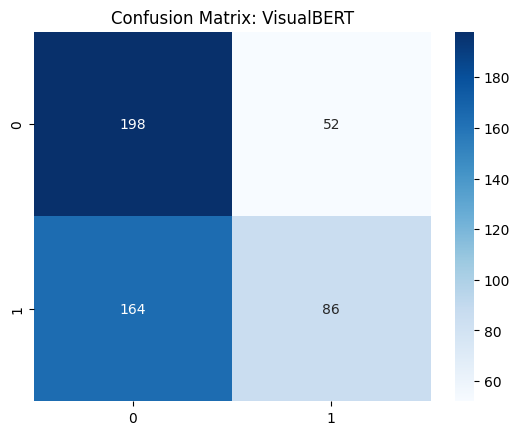


>>> GENERATING FINAL COMPARISON
        Model  Accuracy       AUC
0        CLIP     0.560  0.643840
1  ResNetBERT     0.562  0.630000
2  VisualBERT     0.568  0.645648


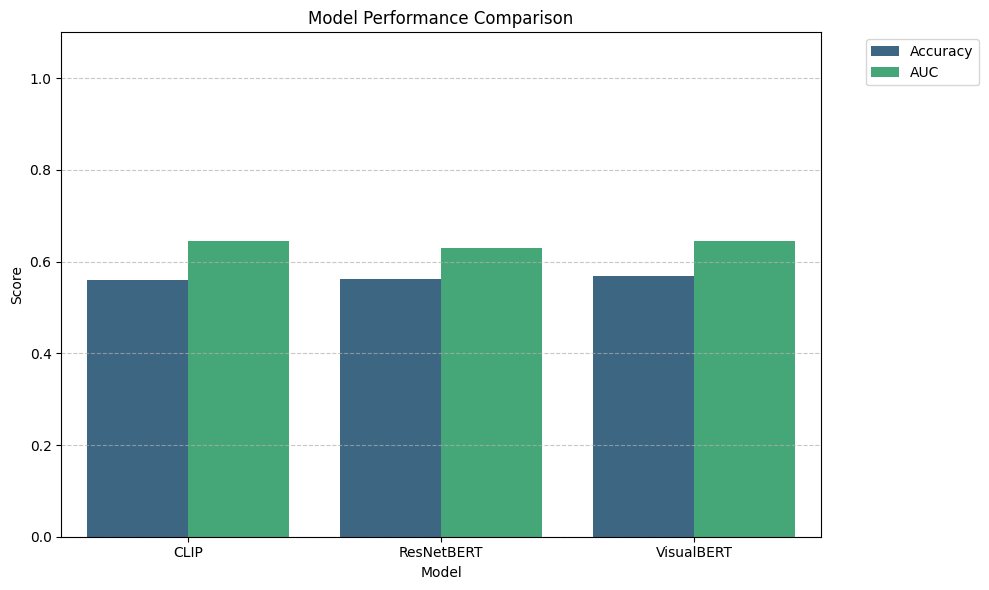

In [22]:
if __name__ == "__main__":
    # Check if data is already loaded to save time
    if 'train_df' not in locals():
        print("Loading Data...")
        train_df, dev_df, test_df = load_and_preprocess_data(Config.data_root)

    if train_df is not None:
        # --- FIX IS HERE: Only run VisualBERT ---
        # The results from CLIP and ResNetBERT are likely already inside 'model_comparison'
        # from your previous run up until the error.
        models_to_run = ["VisualBERT"]
        # ----------------------------------------

        for model_name in models_to_run:
            # Check if this model is already in results to avoid duplicates
            if model_name not in model_comparison['Model']:
                run_training(model_name, train_df, dev_df, test_df)
            else:
                print(f"Skipping {model_name}, already processed.")

        # Final Comparison Plot
        print("\n>>> GENERATING FINAL COMPARISON")

        # Ensure dictionary lists are of equal length before creating DataFrame
        # (In case the error caused a mismatch in appended lists)
        min_len = min(len(model_comparison[k]) for k in model_comparison)
        clean_comparison = {k: v[:min_len] for k, v in model_comparison.items()}

        results_df = pd.DataFrame(clean_comparison)
        print(results_df)

        if not results_df.empty:
            results_melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

            plt.figure(figsize=(10, 6))
            sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric', palette='viridis')
            plt.title("Model Performance Comparison")
            plt.ylim(0, 1.1)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()